# SF Crime PSET 1

1. [Introduction](#intro)
2. [Getting the Data](#data)
3. [Descriptive Statistics](#stats)
4. [Geographic Information Systems](#gis)
5. [Discussion Questions](#dq)

In [2]:
# imports
import requests
from datascience import *
import matplotlib.pyplot as plt
import datetime
import folium
import time
%matplotlib inline

## 1. Introduction <a id='intro'></a>

For this lab, we will be working with the San Francisco Police Department's Incident Database. The dataset contains up-to-date information on incidents reported to the SFPD. Each observation is tagged with information about the incident's location, type of infraaction, and date/time. In this lab you will:

1. Download the data through an Application Programming Interface (API)
2. Explore the data with summary and descriptive statistics
3. Map the incidents

Make sure to start early and ask lots of questions! The dataset, along with other publicaly available data, is available at: https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry

## 2. Getting the Data <a id='data'></a>

Write code that pulls the data into your environment with an API call. Here is the link to the API: https://data.sfgov.org/resource/PdId.json

In [2]:
# the url that we want to get our data from
data_url = 'https://data.sfgov.org/resource/PdId.json?$limit=1&$offset=0&$order=date DESC'

# making our http request to DATA_URL
response = requests.get(data_url)
# using the built-in json decoder of the requests library to interpret the text
json_response = response.json()
len(json_response)

1

In [3]:
#ts = Table(data.labels)
offset = 0
n = 2
recs = []
while n > 0:
    print(n)
    lnk = 'https://data.sfgov.org/resource/PdId.json?$limit=50000&$offset={}&$order=date DESC'.format(str(offset))
    r = requests.get(lnk)
    js = r.json()
    recs.extend(js)
    offset += 50000
    n -= 1
len(recs)

2
1


100000

In [4]:
import pandas as pd
df = pd.DataFrame(recs)
df.head()

address        category                 date dayofweek  \
0     200 Block of LOOMIS ST  OTHER OFFENSES  2017-12-10T00:00:00    Sunday   
1     200 Block of LOOMIS ST  OTHER OFFENSES  2017-12-10T00:00:00    Sunday   
2  CHESTNUT ST / COLUMBUS AV    NON-CRIMINAL  2017-12-10T00:00:00    Sunday   
3   300 Block of VALENCIA ST       VANDALISM  2017-12-10T00:00:00    Sunday   
4   1800 Block of MISSION ST        BURGLARY  2017-12-10T00:00:00    Sunday   

                                descript incidntnum  \
0               TRAFFIC VIOLATION ARREST  170997501   
1  DRIVERS LICENSE, SUSPENDED OR REVOKED  170997501   
2                         FOUND PROPERTY  170997523   
3   MALICIOUS MISCHIEF, BREAKING WINDOWS  170997539   
4               BURGLARY, UNLAWFUL ENTRY  170997545   

                                            location pddistrict  \
0  {'latitude': '37.7387342329071', 'human_addres...    BAYVIEW   
1  {'latitude': '37.7387342329071', 'human_addres...    BAYVIEW   
2  {'latitude': '37.803540856577484', 'human_addr...    CENTRAL   
3  {'latitude': '37.767010470780036', 'human_addr...    MISSION   
4  {'latitude': '37.76745403441758', 'human_addre...    MISSION   

             pdid      resolution   time                    x  \
0  17099750165010            NONE  23:39  -122.40567854634861   
1  17099750165016            NONE  23:39  -122.40567854634861   
2  17099752372000            NONE  00:01   -122.4148785277667   
3  17099753928100            NONE  00:45  -122.42202013701305   
4  17099754505073  ARREST, BOOKED  00:29  -122.41997085985693   

                    y  
0    37.7387342329071  
1    37.7387342329071  
2  37.803540856577484  
3  37.767010470780036  
4   37.76745403441758

In [7]:
data = Table.from_df(df.drop('location', axis=1))

In [8]:
min(df['date'])

'2017-04-14T00:00:00'

In [5]:
# making a table out of our json
data = Table.from_records(json_response)
data.show(3)

NameError: name 'json_response' is not defined

In [17]:
data['y'] = data['y'].astype('float')
data['x'] = data['x'].astype('float')

<font color='blue'><b>QUESTION: What are the advantages to downloading data this way, instead of with a point-and-click action?</b></font color>

## 3. Descriptive Statistics <a id='stats'></a>

Plot the number of incidents per year from 2000-2017 (choose the appropriate type of plot). Have crime rates increased or decreased in general? 

In [9]:
# creating a year column from the first four characters of the 'date' column
data['year'] = [int(d[:4]) for d in data['date']]

In [10]:
agg_on_year = data.group('year')
agg_on_year.show()

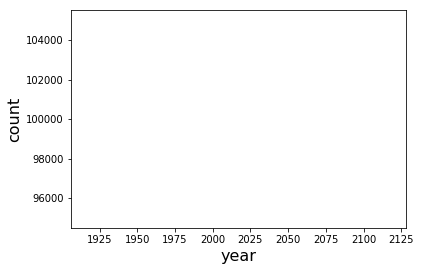

In [11]:
agg_on_year.plot('year', 'count')

Looking just at 2017, what proportion of the total does each type of crime constitute? Use at least one table and at least one plot to support your answer.

In [12]:
agg_by_crime = data.where('year', 2017).group('category')
agg_by_crime['proportion'] = [count / sum(agg_by_crime.column('count')) for count in agg_by_crime.column('count')]
agg_by_crime.sort('proportion', descending=True)

category       | count | proportion
LARCENY/THEFT  | 31439 | 0.31439
OTHER OFFENSES | 11386 | 0.11386
NON-CRIMINAL   | 11216 | 0.11216
ASSAULT        | 9052  | 0.09052
VANDALISM      | 6405  | 0.06405
SUSPICIOUS OCC | 3856  | 0.03856
BURGLARY       | 3647  | 0.03647
VEHICLE THEFT  | 3616  | 0.03616
WARRANTS       | 3277  | 0.03277
MISSING PERSON | 2972  | 0.02972
... (29 rows omitted)

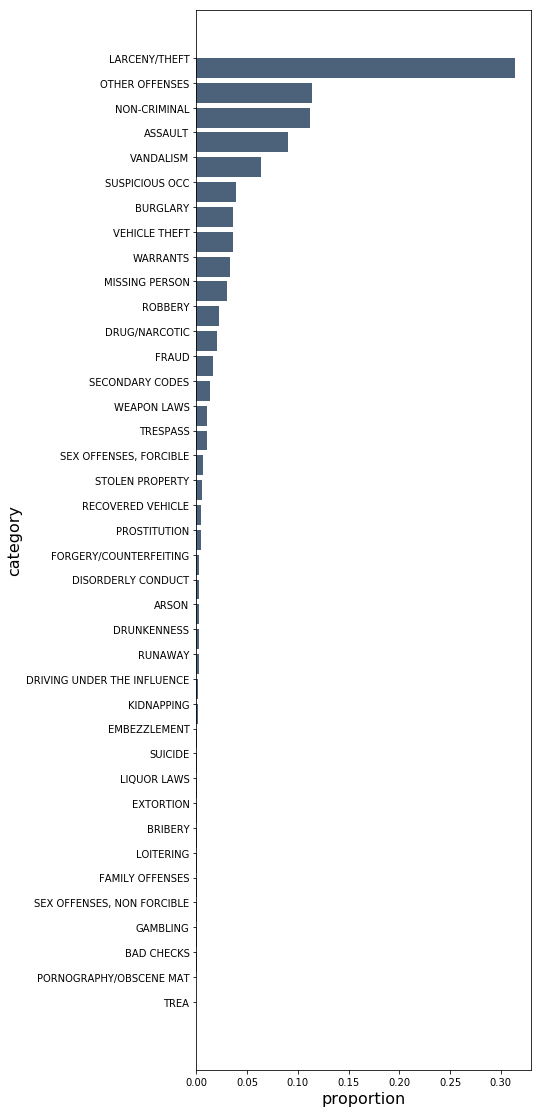

In [13]:
agg_by_crime.sort('count', descending=True).barh('category', 'proportion')

Is there a relationship between day of week, time, and whether an incident occurs? Bonus: Is there a relationship between day/time and particular types of incidents?

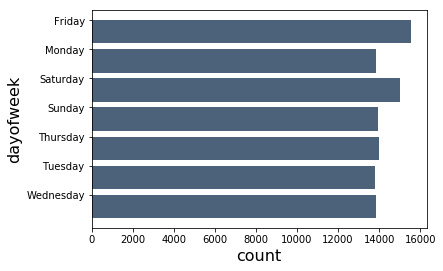

In [14]:
data.group('dayofweek').barh('dayofweek')

In [15]:
# making an hour column that can be grouped on
data['hour'] = [int(t[:2]) for t in data['time']]

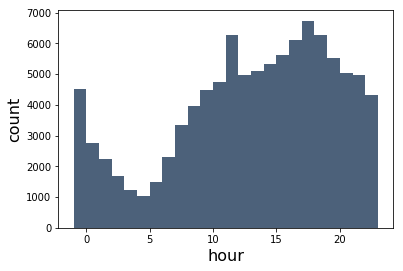

In [16]:
data.group('hour').bar('hour')

#### Bonus: Are there any other interesting relationships in the data?

# 4. Geographic Information Systems (GIS) <a id='gis'></a>

Plot individual incidents in 2017 as points on a map of San Francisco. Does crime seem randomly distributed in space, or do incidents tend to cluster close together? Propose an explanation for your conclusion. Bonus: Shade the points by type of crime.

Hint: Use the `basemap` extension to the `matplotlib` package!

In [68]:
mp = folium.Map(location=[37.7749, -122.4194])
for coords in list(zip(data['y'], data['x'])):
    folium.Circle(
        radius=100,
        location=coords,
        color='crimson',
        fill=False,).add_to(mp)
mp

In [20]:
from folium.plugins import HeatMap

mp = folium.Map(location=[37.7749, -122.4194])
HeatMap(list(zip(data['y'], data['x']))).add_to(mp)
mp

ImportError: cannot import name 'HeatMap'

Merge the incidents data with either a Shapefile or GeoJSON file with information on the boundaries of neighborhoods in San Francisco. 

The neighborhood data is available here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

The API endpoint: https://data.sfgov.org/resource/xfcw-9evu.json

*.geojson

In [54]:
response = requests.get('https://data.sfgov.org/resource/xfcw-9evu.geojson')
geojson = response.json()

In [102]:
# might be too big bc won't display
m = folium.Map(
    location=[37.7749, -122.4194]

)
folium.GeoJson('data.geojson').add_to(m)
m

In [78]:
# works when I cut out a bunch of the polygons
m = folium.Map(
    location=[37.7749, -122.4194],
    zoom_start=12
)

folium.GeoJson('test.geojson').add_to(m)

for coords in list(zip(data['y'], data['x'])):
    folium.Circle(
        radius=30,
        location=coords,
        color='crimson',
        fill=False,).add_to(m)

m

Construct a choropleth map, coloring in each neighborhood by how many incidents it had in 2017. Bonus: Construct several maps that explore differences by day of week, time of year, time of day, etc.

Do you notice any patters? Are there particular neighborhoods where crime concentrates more heavily?

# 5. Discussion Questions <a id='dq'></a>

Based on the evidence from this lab assignment, why do you think "hot spots" policing became more popular in the last few decades? What are the pros and cons to this kind of approach?

What other sorts of data would help improve your analysis?

In [ ]:
def append_and_follow(t, link, n):
    if n == 0:
        print('Next link (if you want to continue)', link)
        return t
    time.sleep(3)
    print(n)
    r = requests.get(link)
    js = r.json()
    return append_and_follow(t.append(Table.from_records(js['value'])), js['@odata.nextLink'], n-1)

starter = Table(('__id', 'address', 'category', 'date', 'dayofweek', 'descript', 'incidntnum', 
                 'location', 'pddistrict', 'pdid', 'resolution', 'time', 'x', 'y'))
starting_url = 'https://data.sfgov.org/api/odata/v4/tmnf-yvry'

c = append_and_follow(starter, starting_url, 6)
c